# time series for forecating

In [3]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
#from pyramid.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet

from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [4]:
# Importing the data
df=pd.read_csv('international-airline-passengers.csv')


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 2 columns):
 #   Column                                                                          Non-Null Count  Dtype  
---  ------                                                                          --------------  -----  
 0   Month                                                                           145 non-null    object 
 1   International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [6]:
df.columns=['year','passengers']

In [7]:
df.head(3)

,year,passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0


In [8]:
df.tail()

,year,passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [9]:
df.drop(144,axis=0,inplace=True)

In [10]:
df.describe()

,passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [11]:
df.describe(include='O')

,year
count,144
unique,144
top,1953-07
freq,1


In [12]:
print('Time period start:{}\n Time period end:{}'.format(df.year.min(),df.year.max()))

Time period start:1949-01
 Time period end:1960-12


In [13]:
df.columns

Index(['year', 'passengers'], dtype='object')

In [14]:
df.shape

(144, 2)

# Data processing and visualization

In [15]:
df['year']=pd.to_datetime(df['year'],format='%Y-%m')

In [16]:
y=df.set_index('year')

In [17]:
y.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01', '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01', '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'], dtype='datetime64[ns]', name='year', length=144, freq=None)

In [18]:
y.isnull().sum()

passengers    0
dtype: int64

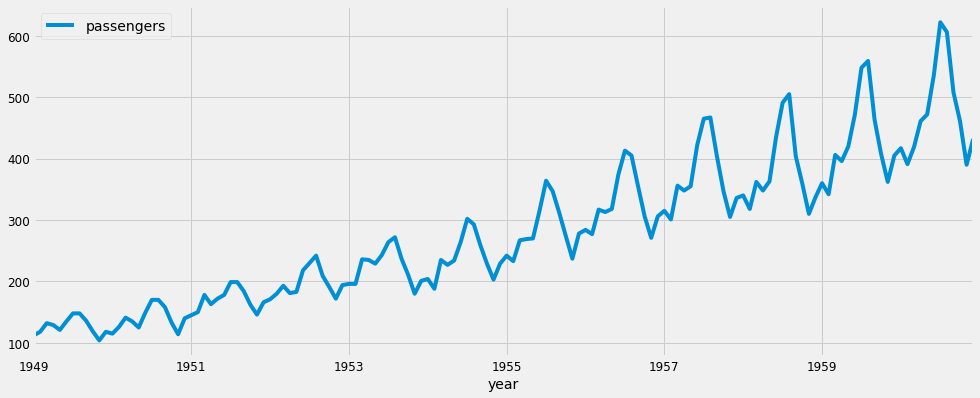

In [19]:
y.plot(figsize=(15,6))
plt.show()

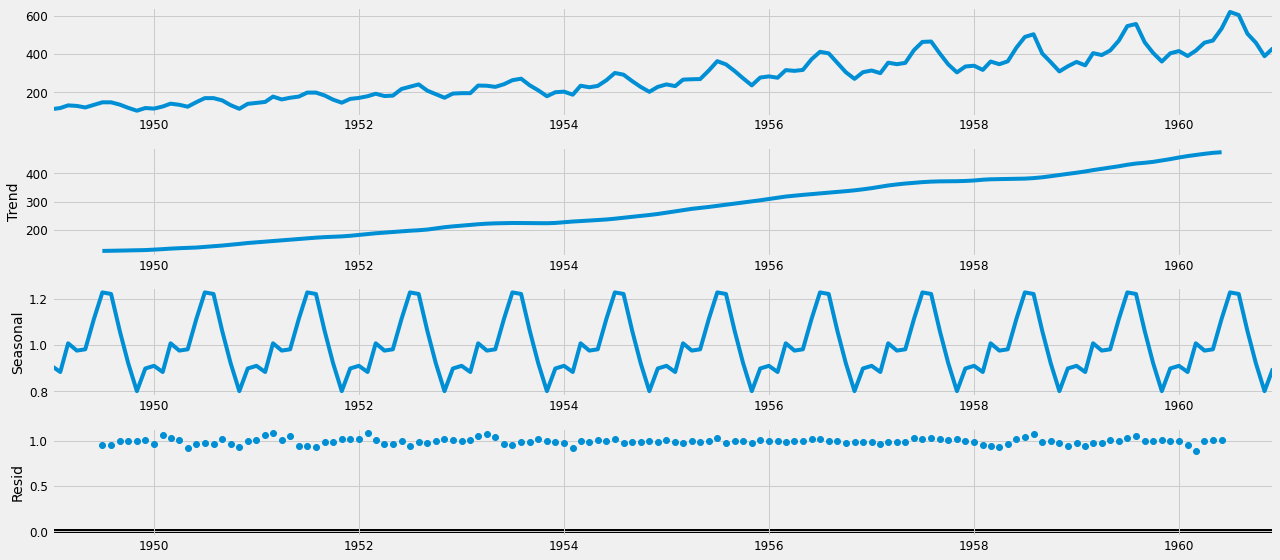

In [20]:
from pylab import rcParams
rcParams['figure.figsize']=18,8

decomposition=sm.tsa.seasonal_decompose(y,model='multiplicative')
fig=decomposition.plot()
plt.show()

# ACF and PACF plots
Let's review the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots
If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.
This data is non-stationary as a high number of previous observations are correlated with future values.
Confidence intervals are drawn as a cone.
By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.
The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

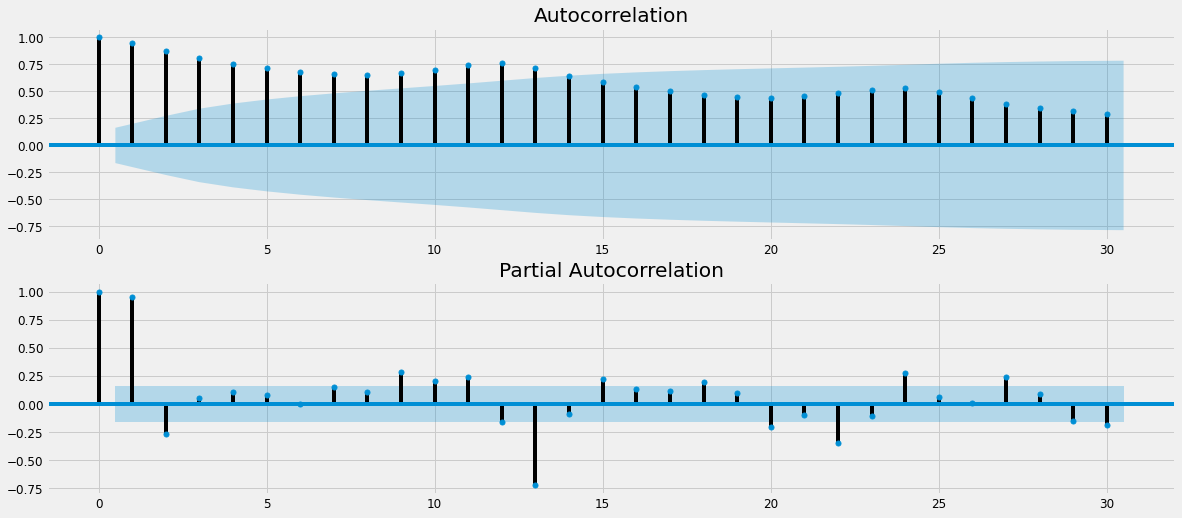

In [21]:
from pandas import Series
from matplotlib import pyplot 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(y.passengers, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(y.passengers, ax=pyplot.gca(), lags = 30)
pyplot.show()

# Rolling Statistics
We observe that the rolling mean and Standard deviation are not constant with respect to time (increasing trend)
The time series is hence not stationary

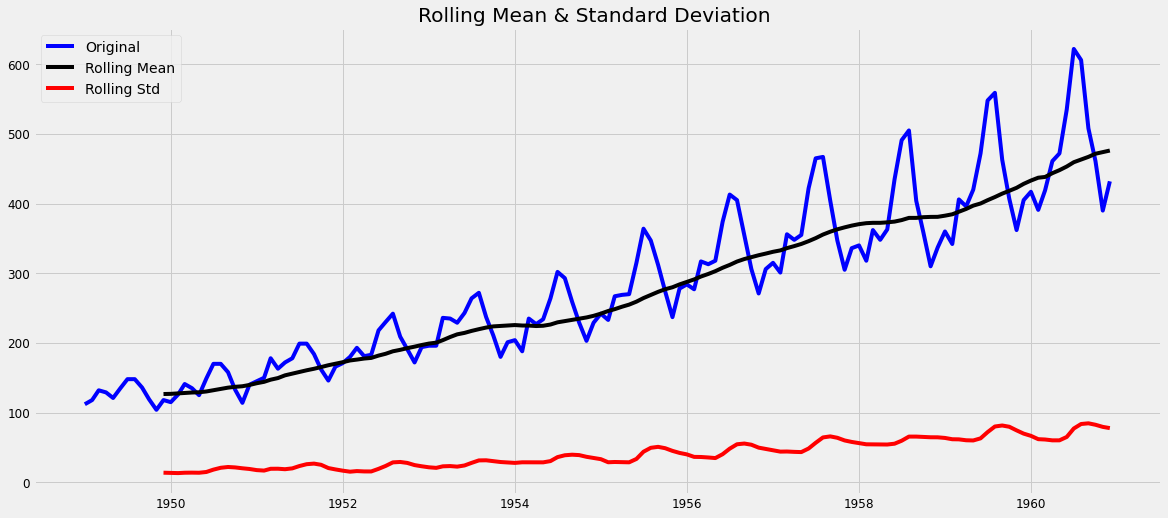

In [22]:
# calcualting the rolling statistics

rolmean=y.rolling(12).mean()
rolstd=y.rolling(12).std()
#rolstd=pd.rolling_std(y,window=12)

#plot the rolling statistics:
orig=plt.plot(y,color='blue',label='Original')
mean=plt.plot(rolmean,color='black',label='Rolling Mean')
std=plt.plot(rolstd,color='red',label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation ')
plt.show(block=False)

# Augmented Dickey-Fuller Test
The intuition behind the test is that if the series is integrated then the lagged level of the series y(t-1) will provide no relevant information in predicting the change in y(t).
Null hypothesis: The time series is not stationary
Rejecting the null hypothesis (i.e. a very low p-value) will indicate staionarity

In [23]:
from statsmodels.tsa.stattools import adfuller

In [24]:
def adfuller_test(passengers):
    result=adfuller(passengers)
    labels=['ADF Test Statistics','p-value','#lags used','No of observation']
    for value,label in zip(result,labels):
     print(label+':'+str(value))
    if result[1]<=0.05:
        print('Reject the null hypothesis')
    else:
        print('Accept the null hypothesis')

In [25]:
adfuller_test(df['passengers'])

ADF Test Statistics:0.8153688792060423
p-value:0.9918802434376409
#lags used:13
No of observation:130
Accept the null hypothesis


# Making the time series stationary

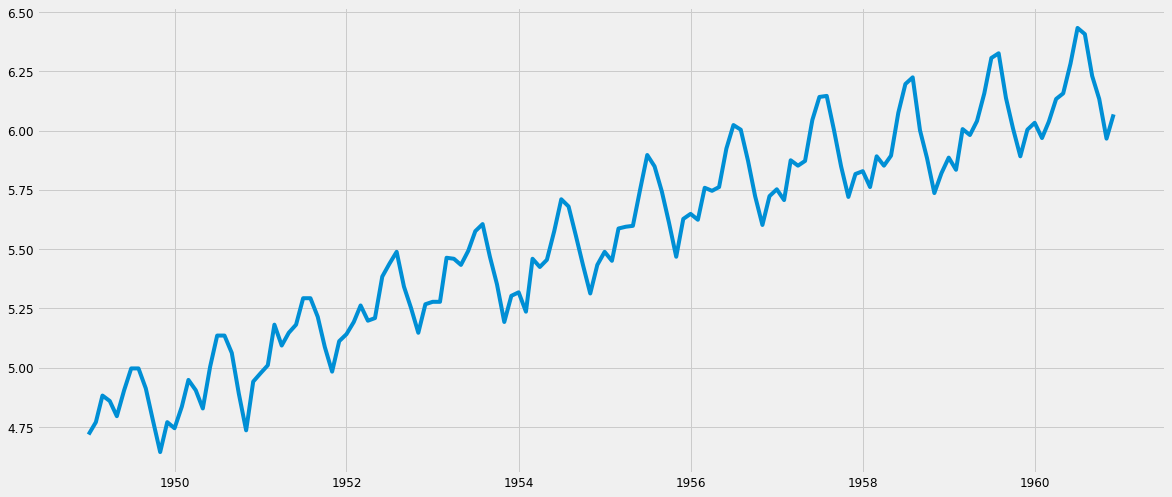

In [26]:
# taking the log transform for simplicity
ts_log=np.log(y)
plt.plot(ts_log)

# Technique to remove the trend


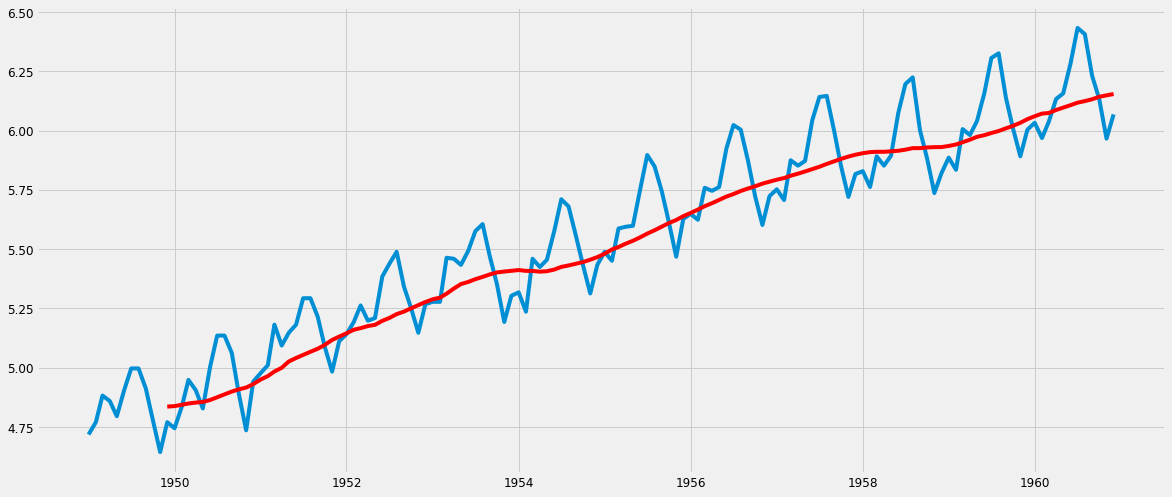

In [27]:
#By using the moving average
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [28]:
ts_log_moving_avg_diff = ts_log.passengers - moving_avg.passengers
ts_log_moving_avg_diff.head(12)

year
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: passengers, dtype: float64

In [29]:
ts_log_moving_avg_diff.dropna(inplace=True)
adfuller_test(ts_log_moving_avg_diff)


ADF Test Statistics:-3.162907991300858
p-value:0.022234630001243844
#lags used:13
No of observation:119
Reject the null hypothesis


# Second method of removing the trend-exponential Moving average

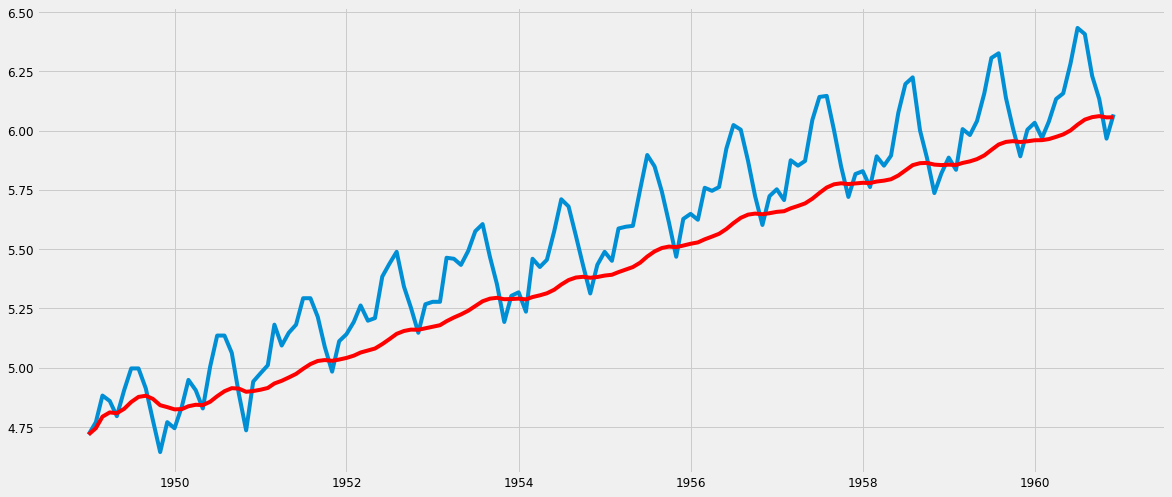

In [30]:
expwighted_avg = ts_log.ewm(halflife=12).mean()

plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

In [31]:
ts_log_ewma_diff = ts_log.passengers - expwighted_avg.passengers
adfuller_test(ts_log_moving_avg_diff)

ADF Test Statistics:-3.162907991300858
p-value:0.022234630001243844
#lags used:13
No of observation:119
Reject the null hypothesis


# technique to remove the seasonality and trends:

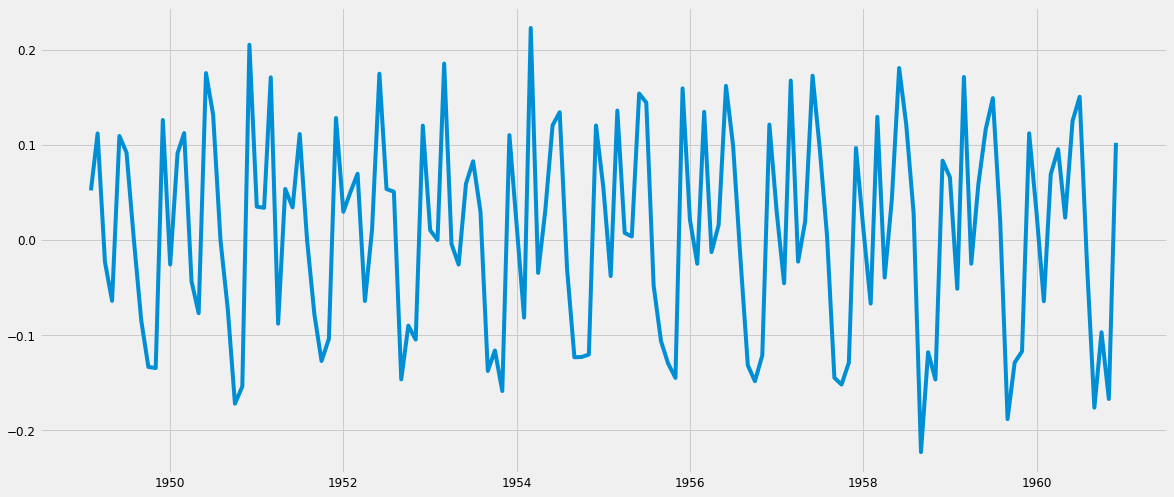

In [32]:
ts_log_diff=ts_log.passengers-ts_log.passengers.shift()
plt.plot(ts_log_diff)

In [33]:
#ts_log_diff.shift(1)

In [34]:
ts_log_diff.dropna(inplace=True)

In [35]:
adfuller_test(ts_log_diff)

ADF Test Statistics:-2.717130598388145
p-value:0.0711205481508568
#lags used:14
No of observation:128
Accept the null hypothesis


In [36]:
#ts_log_diff=ts_log_diff.shift(1)

In [37]:
#ts_log_diff1=ts_log.passengers-ts_log.passengers.shift(12)
#plt.plot(ts_log_diff1)

In [38]:
#ts_log_diff1

In [39]:
#adfuller_test(ts_log_diff1.dropna())

# decomposition

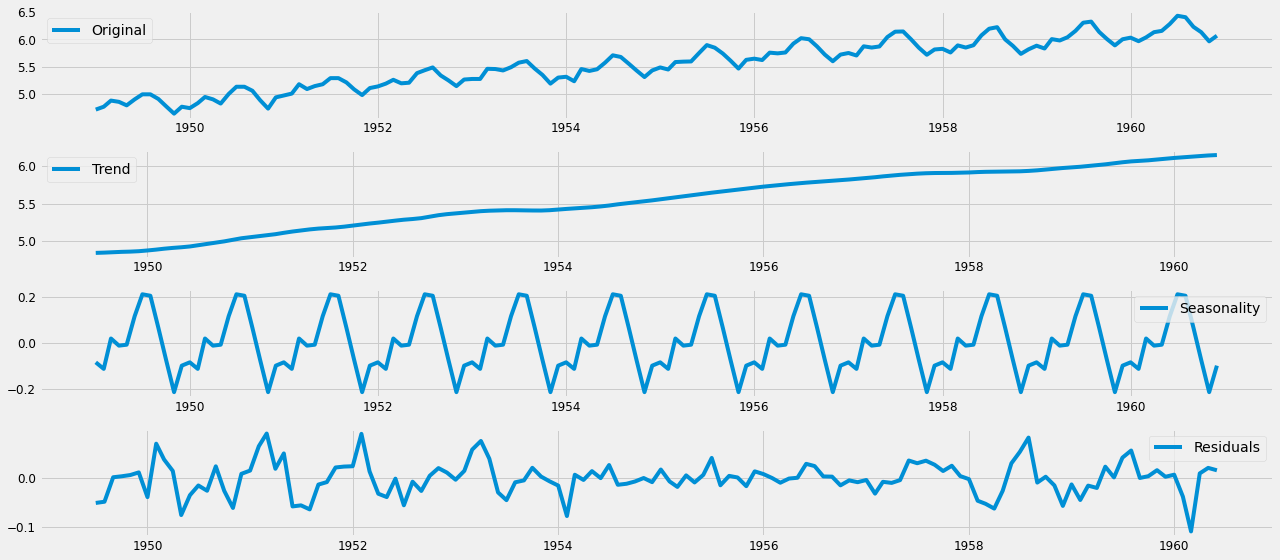

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [41]:
residual = decomposition.resid
residual

year
1949-01-01   NaN
1949-02-01   NaN
1949-03-01   NaN
1949-04-01   NaN
1949-05-01   NaN
              ..
1960-08-01   NaN
1960-09-01   NaN
1960-10-01   NaN
1960-11-01   NaN
1960-12-01   NaN
Name: resid, Length: 144, dtype: float64

In [42]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
adfuller_test(ts_log_decompose)

ADF Test Statistics:-6.3323867976448724
p-value:2.8850589033232728e-08
#lags used:9
No of observation:122
Reject the null hypothesis


# Time Series Forecasting

# 1.AutoRegeressive Model

In [43]:
from statsmodels.tsa.ar_model import AR
from random import random
ts_log_diff.dropna(inplace=True)

In [44]:
#fit the model
model=AR(ts_log_diff)
model_fit=model.fit()

C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


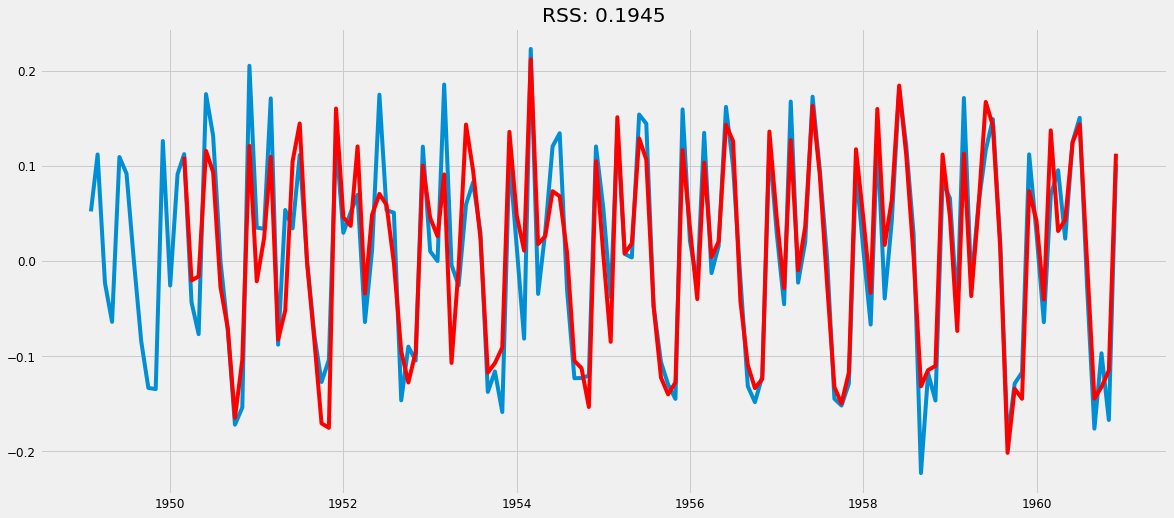

In [45]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))
plt.show()

# Reversing the transformation

In [46]:
predictions_ARIMA_diff = pd.Series(model_fit.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

year
1950-03-01    0.109713
1950-04-01   -0.020423
1950-05-01   -0.016243
1950-06-01    0.115842
1950-07-01    0.093564
dtype: float64


# Cumulative Sum to reverse differencing:

In [47]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

year
1950-03-01    0.109713
1950-04-01    0.089291
1950-05-01    0.073048
1950-06-01    0.188891
1950-07-01    0.282455
dtype: float64


# Adding 1st month value which was previously removed while differencing:

In [48]:
predictions_ARIMA_log = pd.Series(ts_log.passengers.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

year
1949-01-01    4.718499
1949-02-01    4.718499
1949-03-01    4.718499
1949-04-01    4.718499
1949-05-01    4.718499
dtype: float64

# Taking Exponent to reverse Log Transform:

In [49]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)

Text(0.5, 1.0, 'RMSE: 78.5144')

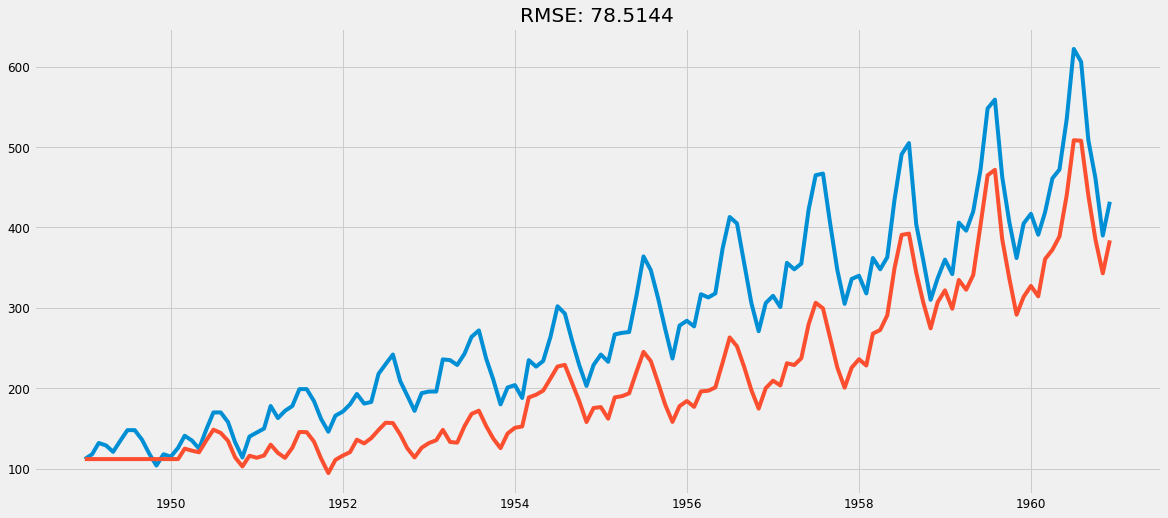

In [50]:
plt.plot(y.passengers)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA-y.passengers)**2)/len(y.passengers)))

# Forecast quality scoring metrics
R squared
Mean Absolute Error
Median Absolute Error
Mean Squared Error
Mean Squared Logarithmic Error
Mean Absolute Percentage Error

~R squared, coefficient of determination (it can be interpreted as a percentage of variance explained by the model), (-inf, 1]

sklearn.metrics.r2_score

~Mean Absolute Error, it is an interpretable metric because it has the same unit of measurement as the initial series, [0, +inf)

sklearn.metrics.mean_absolute_error

~Median Absolute Error, again an interpretable metric, particularly interesting because it is robust to outliers, [0, +inf)

sklearn.metrics.median_absolute_error

~Mean Squared Error, most commonly used, gives higher penalty to big mistakes and vise versa, [0, +inf)

sklearn.metrics.mean_squared_error

~Mean Squared Logarithmic Error, practically the same as MSE but we initially take logarithm of the series, as a result we give attention to small mistakes as well, usually is used when data has exponential trends, [0, +inf)

sklearn.metrics.mean_squared_log_error


~Mean Absolute Percentage Error, same as MAE but percentage, — very convenient when you want to explain the quality of the model to your management, [0, +inf),

not implemented in sklearn

In [51]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,median_absolute_error,mean_squared_log_error 

In [52]:
r2_score(y.passengers,predictions_ARIMA)

0.5686734896130738

In [53]:
mean_absolute_error(y.passengers,predictions_ARIMA)

69.42862838872753

In [54]:
median_absolute_error(y.passengers,predictions_ARIMA)

69.36695435384787

In [55]:
mean_squared_error(y.passengers,predictions_ARIMA)

6164.506983577638

In [56]:
mean_squared_log_error (y.passengers,predictions_ARIMA)

0.09945599448249762

In [57]:
#mean percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mean_absolute_percentage_error(y.passengers, predictions_ARIMA)

24.47240542986236

# Function to evaluate forecast using above metrics:

In [58]:
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [59]:
evaluate_forecast(y.passengers, predictions_ARIMA)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.568673,69.428628,69.366954,6164.506984,0.099456,24.472405,78.514374


# Moving average

In [60]:
#MA example

from statsmodels.tsa.arima_model import ARMA
from random import random

#fit model
model=ARMA(ts_log_diff,order=(0,1))
model_fit=model.fit(disp=False)


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [62]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             passengers   No. Observations:                  143
Model:                     ARMA(0, 1)   Log Likelihood                 121.754
Method:                       css-mle   S.D. of innovations              0.103
Date:                Tue, 12 Jan 2021   AIC                           -237.507
Time:                        10:52:05   BIC                           -228.619
Sample:                    02-01-1949   HQIC                          -233.895
                         - 12-01-1960                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0097      0.011      0.887      0.375      -0.012       0.031
ma.L1.passengers     0.2722      0.095      2.873      0.004       0.086       0.458
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -3.6744           +0.0000j            3.6744            0.5000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 1.5245')

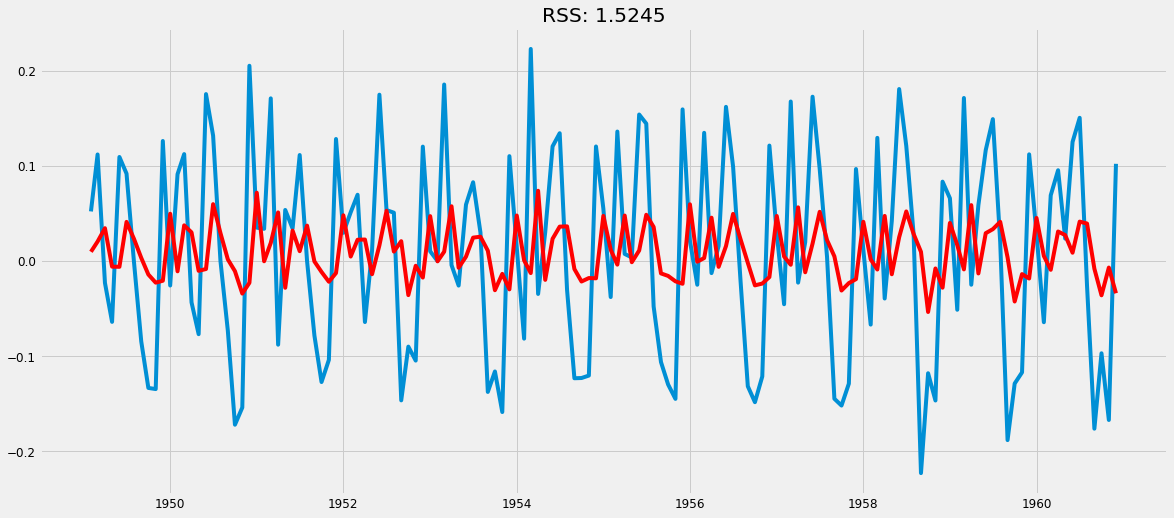

In [63]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

# Autoregressive Moving Average (ARMA)
Number of AR (Auto-Regressive) terms (p): p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
Number of MA (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

In [64]:
# ARMA example
from statsmodels.tsa.arima_model import ARMA
from random import random

# fit model
model = ARMA(ts_log_diff, order=(2, 1))
model_fit = model.fit(disp=False)

C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [65]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             passengers   No. Observations:                  143
Model:                     ARMA(2, 1)   Log Likelihood                 140.076
Method:                       css-mle   S.D. of innovations              0.090
Date:                Tue, 12 Jan 2021   AIC                           -270.151
Time:                        10:54:32   BIC                           -255.337
Sample:                    02-01-1949   HQIC                          -264.131
                         - 12-01-1960                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0101      0.000     23.509      0.000       0.009       0.011
ar.L1.passengers     0.9982      0.076     13.162      0.000       0.850       1.147
ar.L2.passengers    -0.4134      0.077     -5.383      0.000      -0.564      -0.263
ma.L1.passengers    -0.9999      0.028    -35.273      0.000      -1.056      -0.944
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2073           -0.9805j            1.5553           -0.1086
AR.2            1.2073           +0.9805j            1.5553            0.1086
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 1.1753')

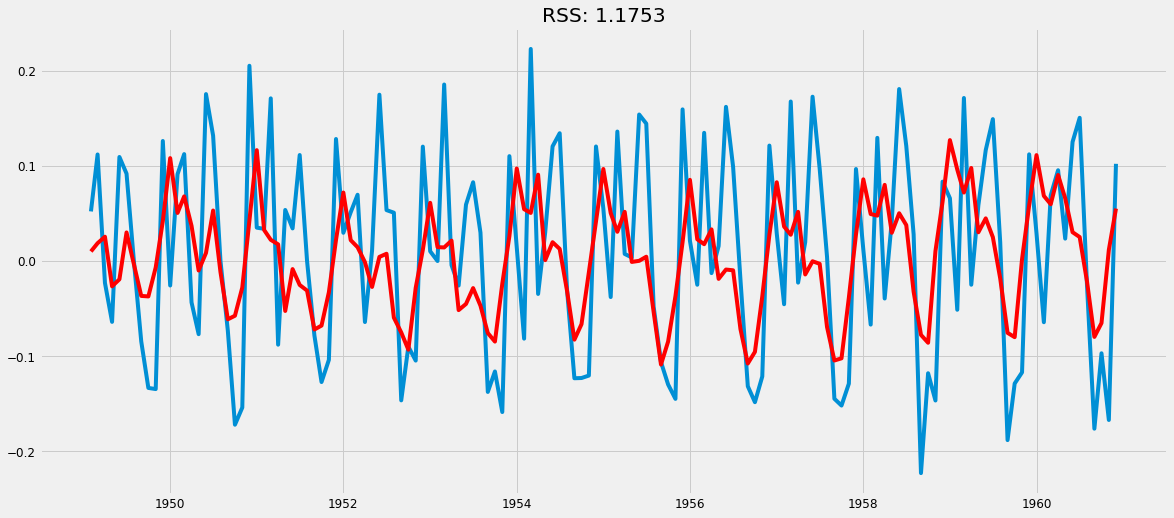

In [66]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

# AutoRegressive Integrated Moving Average(ARIMA)

In [67]:
ts=y.passengers-y.passengers.shift()
ts.dropna(inplace=True)

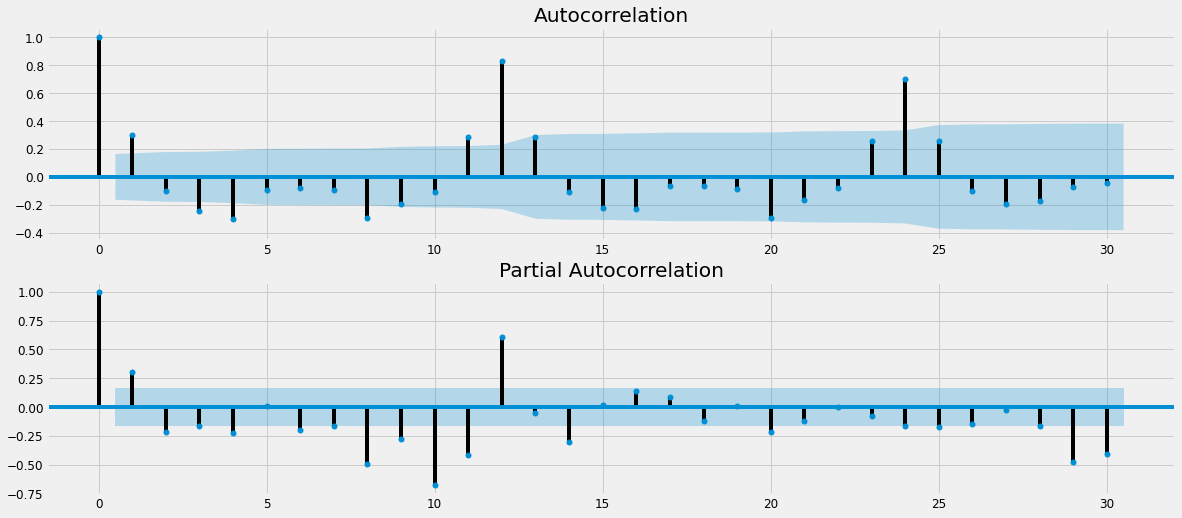

In [70]:
pyplot.figure()
pyplot.subplot(211)
plot_acf(ts,ax=pyplot.gca(),lags=30)
pyplot.subplot(212)
plot_pacf(ts,ax=pyplot.gca(),lags=30)
pyplot.show()

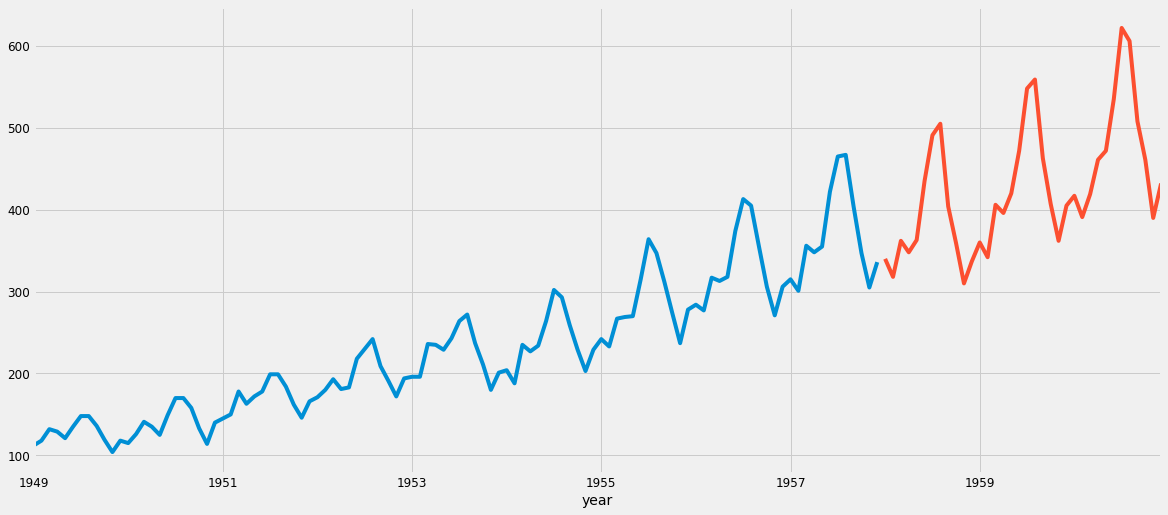

In [72]:
#divide into train and validate set

train=y[:int(0.75*(len(y)))]
validate=y[int(0.75*(len(y))):]
             
#plotting the data
train['passengers'].plot()
validate['passengers'].plot()             

In [73]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# fit model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit(disp=1)

C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [74]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.passengers   No. Observations:                  107
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -493.230
Method:                       css-mle   S.D. of innovations             23.986
Date:                Tue, 12 Jan 2021   AIC                            994.461
Time:                        11:15:04   BIC                           1005.152
Sample:                    02-01-1949   HQIC                           998.795
                         - 12-01-1957                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.4356      0.265      9.186      0.000       1.916       2.955
ar.L1.D.passengers     0.7409      0.067     10.991      0.000       0.609       0.873
ma.L1.D.passengers    -1.0000      0.025    -39.435      0.000      -1.050      -0.950
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3496           +0.0000j            1.3496            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [79]:
start_index = validate.index.min()
end_index = validate.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [80]:
# report performance
mse = mean_squared_error(y[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 432.6263795360257, MSE:187165.58427044936


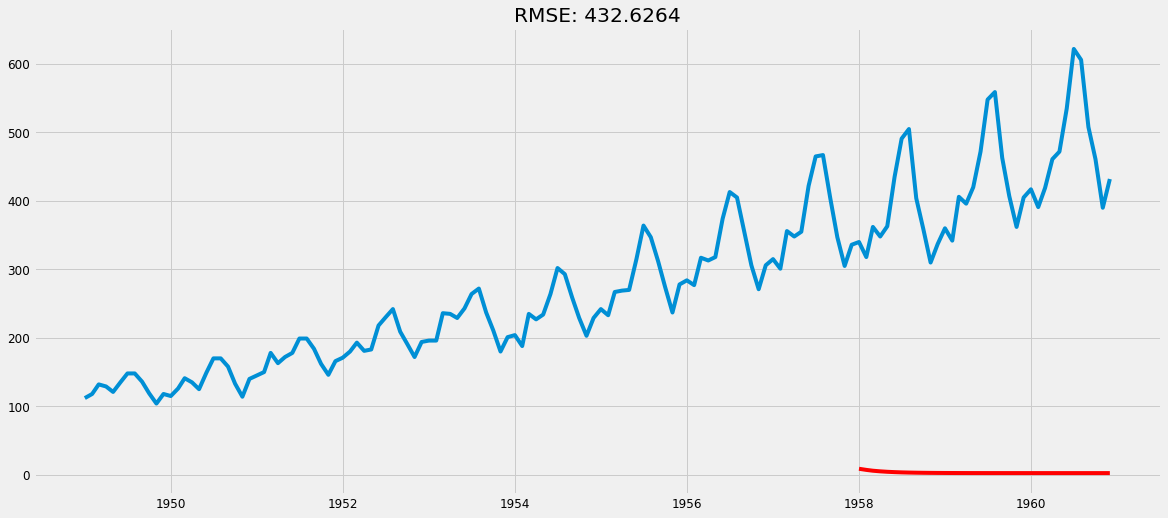

In [81]:
plt.plot(y.passengers)
plt.plot(predictions, color='red')
plt.title('RMSE: %.4f'% rmse)
plt.show()

In [83]:
#Fitted or predicted values:


predictions_ARIMA_diff = pd.Series(predictions, copy=True)
print (predictions_ARIMA_diff.head())

1958-01-01    8.743429
1958-02-01    7.109323
1958-03-01    5.898545
1958-04-01    5.001430
1958-05-01    4.336719
Freq: MS, dtype: float64


In [84]:
#Cumulative Sum to reverse differencing:


predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

1958-01-01     8.743429
1958-02-01    15.852752
1958-03-01    21.751297
1958-04-01    26.752727
1958-05-01    31.089446
Freq: MS, dtype: float64


In [87]:
#Adding 1st month value which was previously removed while differencing:


predictions_ARIMA_log = pd.Series(validate.passengers.iloc[0], index=validate.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

year
1958-01-01    348.743429
1958-02-01    355.852752
1958-03-01    361.751297
1958-04-01    366.752727
1958-05-01    371.089446
dtype: float64

# Taking Exponent to reverse Log Transform:

Text(0.5, 1.0, 'RMSE: 205.2935')

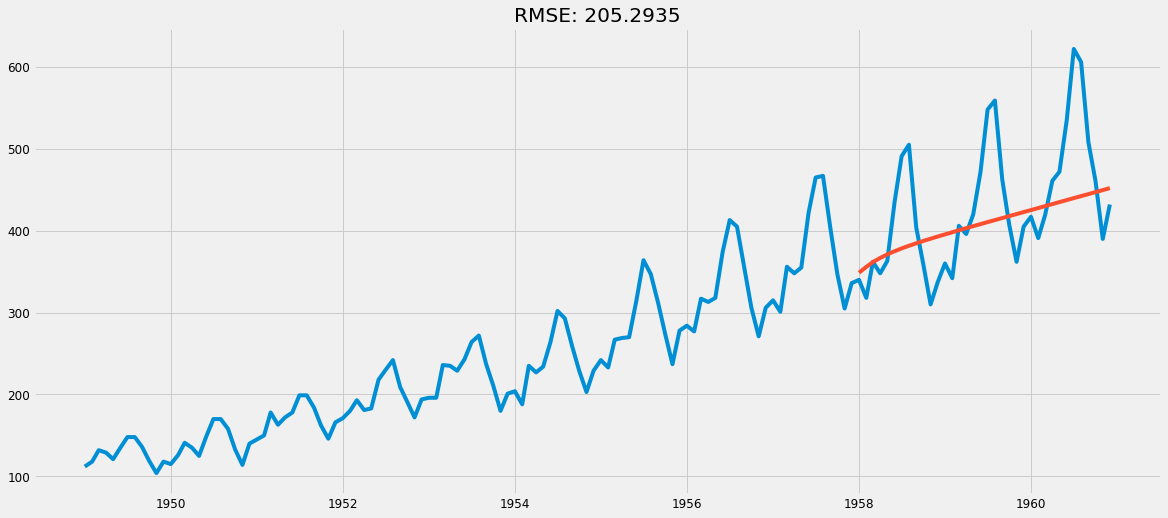

In [88]:
plt.plot(y.passengers)
plt.plot(predictions_ARIMA_log)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA_log-ts)**2)/len(ts)))

In [89]:
evaluate_forecast(y[start_index:end_index], predictions_ARIMA_log)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.179865,52.106955,36.843691,5017.836055,0.023691,NaN,70.836686


# Auto ARIMA

In [90]:
#building the model
from pyramid.arima import auto_arima
model=auto_arima(train,trace=True,error_action='ignore',suppress_warnings=True)
model.fit(train)

ModuleNotFoundError: No module named 'pyramid'

# Seasonal autoregressive integrated moving avareage(sarima)

In [92]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [102]:
#fitm model

model=SARIMAX(train,order=(3,1,3),seasonal_order=(1,1,1,12))
model.fit=model.fit(disp=False)

C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [103]:
start_index=validate.index.min()
end_index=validate.index.max()

In [104]:
#predictions
predictions=model_fit.predict(start_index,end_index)


In [105]:
# report performance
mse = mean_squared_error(y[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 432.6263795360257, MSE:187165.58427044936


Text(0.5, 1.0, 'RMSE: 432.6264')

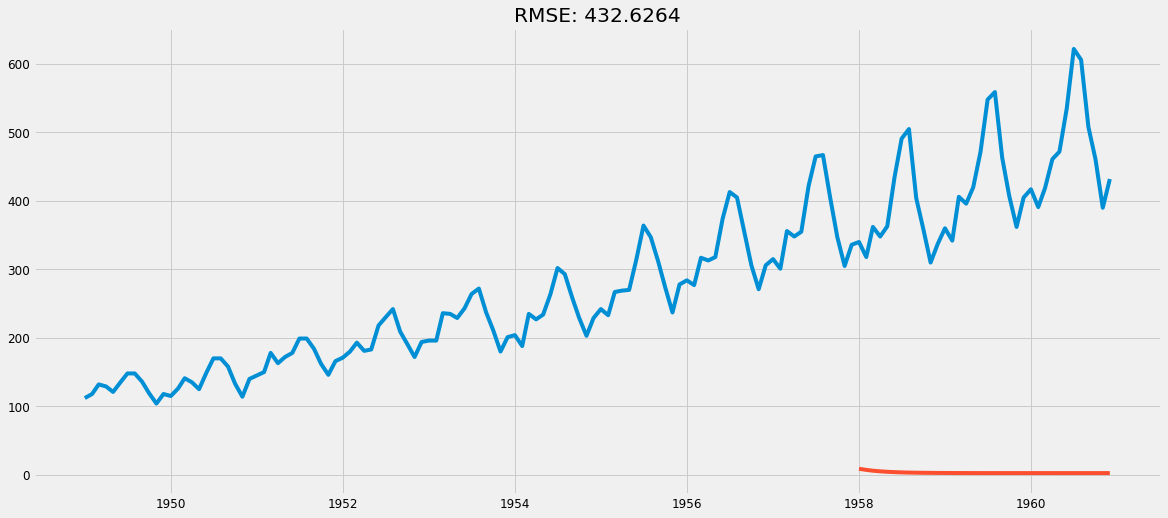

In [106]:
plt.plot(y)
plt.plot(predictions)
plt.title('RMSE: %.4f'% rmse)

In [107]:
evaluate_forecast(y[start_index:end_index], predictions)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,-29.591082,425.388088,409.556266,187165.58427,21.97617,NaN,432.62638


# tuned SARIMA

In [108]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 6)
SARIMAX: (0, 0, 1) x (0, 1, 0, 6)
SARIMAX: (0, 1, 0) x (0, 1, 1, 6)
SARIMAX: (0, 1, 0) x (1, 0, 0, 6)


In [109]:
min_aic = 999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            #Check for best model with lowest AIC
            if results.aic < min_aic:
                min_aic = results.aic
                min_aic_model = results
        except:
            continue

C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 0, 0)x(0, 0, 0, 6)12 - AIC:1484.6772209911371
ARIMA(0, 0, 0)x(0, 0, 1, 6)12 - AIC:1332.7081717070828
ARIMA(0, 0, 0)x(0, 1, 0, 6)12 - AIC:1106.9983169558561


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 0, 0)x(0, 1, 1, 6)12 - AIC:1015.2677070055556


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(0, 0, 0)x(1, 0, 0, 6)12 - AIC:1115.9461051704866


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 0, 0)x(1, 0, 1, 6)12 - AIC:1001.475594651184
ARIMA(0, 0, 0)x(1, 1, 0, 6)12 - AIC:951.0958895418044

C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 0, 0)x(1, 1, 1, 6)12 - AIC:860.2555893282284
ARIMA(0, 0, 1)x(0, 0, 0, 6)12 - AIC:1334.2309362006258

C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 0, 1)x(0, 0, 1, 6)12 - AIC:1194.1257357113416
ARIMA(0, 0, 1)x(0, 1, 0, 6)12 - AIC:998.491212125741

C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 0, 1)x(0, 1, 1, 6)12 - AIC:912.8780689438499


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 0, 1)x(1, 0, 0, 6)12 - AIC:1018.9733569272415


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 0, 1)x(1, 0, 1, 6)12 - AIC:914.9884749527137


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 0, 1)x(1, 1, 0, 6)12 - AIC:866.3727396684192


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 0, 1)x(1, 1, 1, 6)12 - AIC:792.5520246439561
ARIMA(0, 1, 0)x(0, 0, 0, 6)12 - AIC:993.1312724630138


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(0, 0, 1, 6)12 - AIC:943.9245123003233
ARIMA(0, 1, 0)x(0, 1, 0, 6)12 - AIC:999.3755478796342


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(0, 1, 1, 6)12 - AIC:853.8944017297785
ARIMA(0, 1, 0)x(1, 0, 0, 6)12 - AIC:952.2256377506902


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(1, 0, 1, 6)12 - AIC:904.2214139080115
ARIMA(0, 1, 0)x(1, 1, 0, 6)12 - AIC:706.8180283967389


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(1, 1, 1, 6)12 - AIC:700.9697604028893
ARIMA(0, 1, 1)x(0, 0, 0, 6)12 - AIC:973.2055693625707


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(0, 0, 1, 6)12 - AIC:924.7899877817626
ARIMA(0, 1, 1)x(0, 1, 0, 6)12 - AIC:979.0951064213141


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(0, 1, 1, 6)12 - AIC:837.3373300231428
ARIMA(0, 1, 1)x(1, 0, 0, 6)12 - AIC:941.4721477228294


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(1, 0, 1, 6)12 - AIC:886.8511031803769


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(1, 1, 0, 6)12 - AIC:698.3539185876849


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(1, 1, 1, 6)12 - AIC:682.47140921255
ARIMA(1, 0, 0)x(0, 0, 0, 6)12 - AIC:1003.4820392779112


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. 

ARIMA(1, 0, 0)x(0, 0, 1, 6)12 - AIC:954.4121523794579
ARIMA(1, 0, 0)x(0, 1, 0, 6)12 - AIC:1001.1995622331284
ARIMA(1, 0, 0)x(0, 1, 1, 6)12 - AIC:862.1556791798996
ARIMA(1, 0, 0)x(1, 0, 0, 6)12 - AIC:954.218448438449

C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'



ARIMA(1, 0, 0)x(1, 0, 1, 6)12 - AIC:905.0278354968756


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 0, 0)x(1, 1, 0, 6)12 - AIC:707.3904076332474


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 0, 0)x(1, 1, 1, 6)12 - AIC:707.4979558893045
ARIMA(1, 0, 1)x(0, 0, 0, 6)12 - AIC:983.87451537299


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. 

ARIMA(1, 0, 1)x(0, 0, 1, 6)12 - AIC:935.5012436034268
ARIMA(1, 0, 1)x(0, 1, 0, 6)12 - AIC:976.5242009157749


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 0, 1)x(0, 1, 1, 6)12 - AIC:844.8331736022496
ARIMA(1, 0, 1)x(1, 0, 0, 6)12 - AIC:943.5019392938544


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 0, 1)x(1, 0, 1, 6)12 - AIC:884.0817222919527


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 0, 1)x(1, 1, 0, 6)12 - AIC:700.1612844598967


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 0, 1)x(1, 1, 1, 6)12 - AIC:690.5229323388774
ARIMA(1, 1, 0)x(0, 0, 0, 6)12 - AIC:986.4207435070009
ARIMA(1, 1, 0)x(0, 0, 1, 6)12 - AIC:937.2676970229141

C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'



ARIMA(1, 1, 0)x(0, 1, 0, 6)12 - AIC:985.3821728074678


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 0)x(0, 1, 1, 6)12 - AIC:844.0590255096272
ARIMA(1, 1, 0)x(1, 0, 0, 6)12 - AIC:936.3388643486369


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 0)x(1, 0, 1, 6)12 - AIC:893.626886070582
ARIMA(1, 1, 0)x(1, 1, 0, 6)12 - AIC:692.5537522337324

C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 0)x(1, 1, 1, 6)12 - AIC:690.3400926455461
ARIMA(1, 1, 1)x(0, 0, 0, 6)12 - AIC:970.8380288737669


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(0, 0, 1, 6)12 - AIC:922.0887629358762
ARIMA(1, 1, 1)x(0, 1, 0, 6)12 - AIC:977.8777245593707


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(0, 1, 1, 6)12 - AIC:840.6216451347894


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(1, 0, 0, 6)12 - AIC:930.6378133744953


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(1, 0, 1, 6)12 - AIC:886.2198395485813


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(1, 1, 0, 6)12 - AIC:693.0569052897422


C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anita\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(1, 1, 1, 6)12 - AIC:684.3818335827308


In [110]:
min_aic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        passengers   No. Observations:                  108
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 6)   Log Likelihood                -337.236
Date:                           Tue, 12 Jan 2021   AIC                            682.471
Time:                                   11:38:39   BIC                            692.602
Sample:                               01-01-1949   HQIC                           686.562
                                    - 12-01-1957                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4551      0.082     -5.542      0.000      -0.616      -0.294
ar.S.L6       -1.0894      0.017    -65.209      0.000      -1.122      -1.057
ma.S.L6        2.2737      0.600      3.791      0.000       1.098       3.449
sigma2        15.8253      7.949      1.991      0.046       0.246      31.405
===================================================================================
Ljung-Box (Q):                       45.44   Jarque-Bera (JB):                 2.17
Prob(Q):                              0.26   Prob(JB):                         0.34
Heteroskedasticity (H):               0.61   Skew:                             0.37
Prob(H) (two-sided):                  0.17   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [111]:
start_index = validate.index.min()
end_index = validate.index.max()

#Predictions
pred = min_aic_model.get_prediction(start=start_index,end=end_index, dynamic=False)

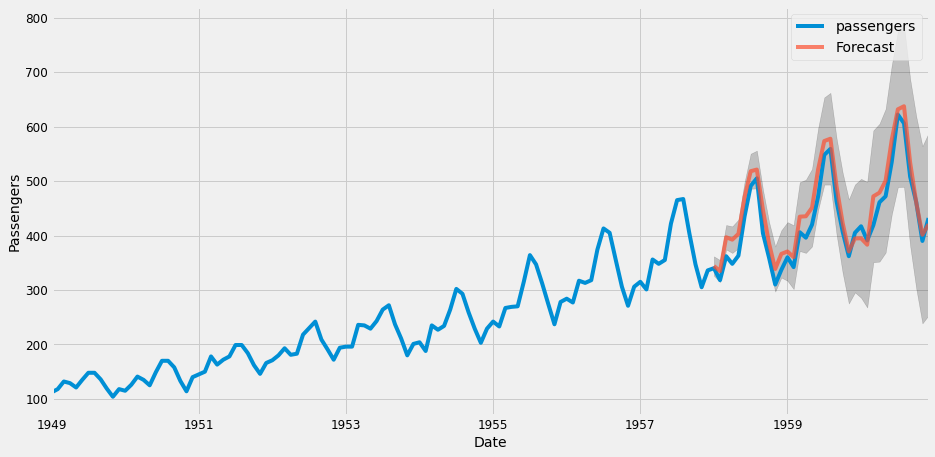

In [112]:
pred_ci = pred.conf_int()
ax = y['1949':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()
plt.show()

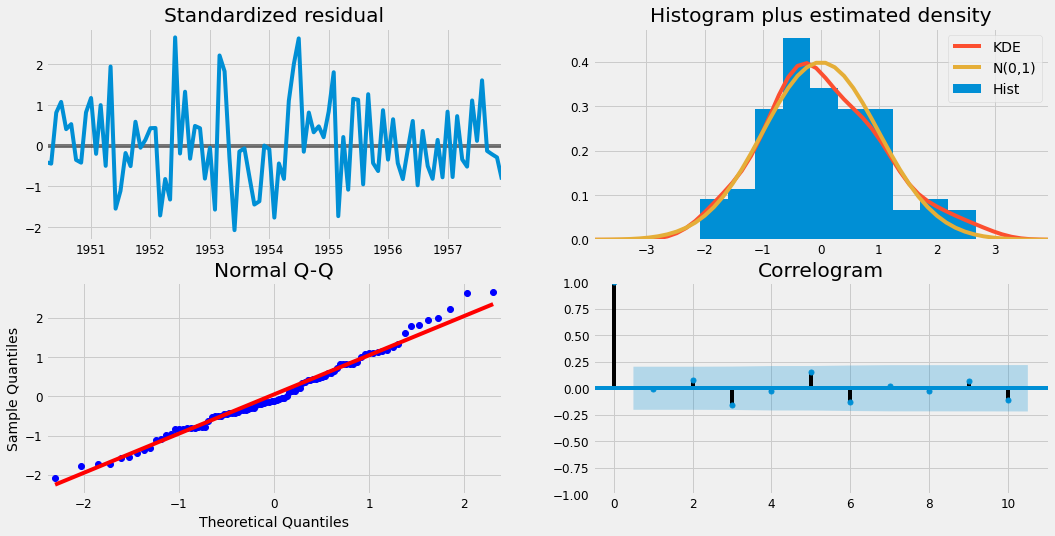

In [113]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

# Model diagnostics:

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean.
If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.
The model diagnostic suggests that the model residual is normally distributed based on the following:

In the top right plot, the red KDE line follows closely with the N(0,1) line. Where, N(0,1) is the standard notation for a normal distribution with mean 0 and standard deviation of 1. This is a good indication that the residuals are normally distributed.
The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution. Again, this is a strong indication that the residuals are normally distributed.
The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise.
This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

In [114]:
y_forecasted = pred.predicted_mean.values
y_truth = y[start_index:end_index].passengers.values
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 781.33


In [115]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 27.95


In [116]:
evaluate_forecast(y_truth, y_forecasted)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.872297,24.730443,26.181615,781.328679,0.004216,5.93168,27.952257


# Prophet

In [117]:
train.head()

,passengers
year,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [126]:
train_prophet=pd.DataFrame()
train_prophet['ds']=train.index
train_prophet['y']=train.passengers.values

In [127]:
train_prophet.head()

,ds,y
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


In [130]:
from fbprophet import Prophet

#instantiate Prophet with only yearly seasonality as our data is monthly 
model = Prophet( yearly_seasonality=True, seasonality_mode = 'multiplicative')
model.fit(train_prophet) #fit the model with your dataframe

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [135]:
# predict for five months in future
future=model.make_future_dataframe(periods=36,freq='MS')
future.tail()

,ds
139,1960-08-01
140,1960-09-01
141,1960-10-01
142,1960-11-01
143,1960-12-01


In [137]:
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
139,1960-08-01,618.747937,602.494356,635.883508
140,1960-09-01,535.714501,519.990051,551.900009
141,1960-10-01,467.354249,452.982966,482.040531
142,1960-11-01,414.836968,401.070736,429.608468
143,1960-12-01,461.106174,445.867073,477.184885


In [138]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'multiplicative_terms', 'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yearly', 'yearly_lower', 'yearly_upper', 'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 'yhat'], dtype='object')

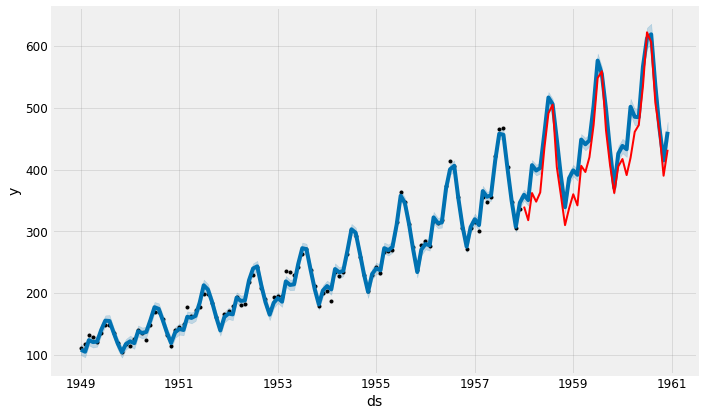

In [140]:
fig = model.plot(forecast)
#plot the predictions for validation set

plt.plot(validate, label='Valid', color = 'red', linewidth = 2)

plt.show()

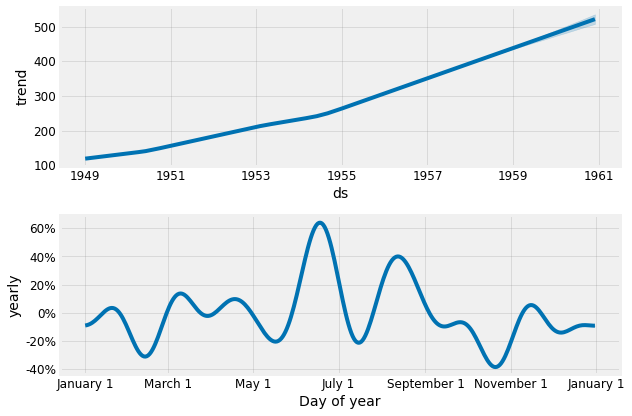

In [141]:
model.plot_components(forecast);

In [142]:
y_prophet = pd.DataFrame()
y_prophet['ds'] = y.index
y_prophet['y'] = y.passengers.values

In [143]:
y_prophet = y_prophet.set_index('ds')
forecast_prophet = forecast.set_index('ds')

In [144]:
evaluate_forecast(y_prophet.y[start_index:end_index], forecast_prophet.yhat[start_index:end_index])

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.814637,29.69586,28.692342,1134.108291,0.006653,7.440315,33.676524
